In [2]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader, PyPDFDirectoryLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

groq_api_key=os.getenv("GROQ_API_KEY")

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama3-8b-8192")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002015A1E4B90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002015A1E5730>, model_name='Llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
os.environ['HUGGINGFACE_API_KEY']=os.getenv("HUGGINGFACE_API_KEY")
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Programming Work\CareerCoach\cc_venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [6]:
import bs4
loader = WebBaseLoader(
    web_paths=("https://www.accenture.com/ie-en/careers/jobdetails?id=R00243560_en&title=Machine%20Learning%20Engineer#accordion-54c4da3570-item-cc64175c33",)
    # ,
    # bs_kwargs=dict(
    #     parse_only=bs4.SoupStrainer(
    #         class_=("post-content", "post-title", "post-header")
    #     )
    # ),
)

web_docs=loader.load()
web_docs

[Document(metadata={'source': 'https://www.accenture.com/ie-en/careers/jobdetails?id=R00243560_en&title=Machine%20Learning%20Engineer#accordion-54c4da3570-item-cc64175c33', 'title': 'Machine Learning Engineer', 'description': 'Learn more about applying for Machine Learning Engineer position at Accenture.', 'language': 'en'}, page_content="\n\n\n\n\nMachine Learning Engineer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\nSkip to footer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nInsights\n\n\nServices\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nCloud\n\t\t\t  \n\t\t  \n\n\nCybersecurity\n\t\t\t  \n\t\t  \n\n\nData and Artificial Intelligence\n\t\t\t  \n\t\t  \n\n\nDigital Engineering and Manufacturing\n\t\t\t  \n\t\t  \n\n\nEmerging Technology\n\t\t\t  \n\t\t  \n\n\nEcosystem Partners\n\t\t\t  \n\t\t  \n\n\nFinance and Risk Management\n\t\t\t  \n\t\t  \

In [7]:
from typing import List, Optional
from pydantic import BaseModel, Field

class Job(BaseModel):
    title: str = Field(description="Job title or position.")
    company: str = Field(description="The company name.")
    location: Optional[str] = Field(description="Location of the job.")
    salary: Optional[str] = Field(description="Salary range for the job.")
    description: str = Field(description="Detailed job description.")
    responsibilities: List[str] = Field(description="List of job responsibilities.")
    benefits: Optional[List[str]] = Field(description="List of job benefits.")
    employment_type: Optional[str] = Field(description="Type of employment (e.g., full-time, part-time).")
    posted_date: Optional[str] = Field(description="Date when the job was posted.")


In [8]:
parser = PydanticOutputParser(pydantic_object=Job)
primary_system_prompt = (
    "You have to extract all the field values from job description."
    "Fields: {fields}"
    
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", primary_system_prompt),
        ("human", "{input}")
    ]
)

input_dict = {"input":web_docs.__str__(), "fields":parser.get_format_instructions()}


In [9]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"title": {"description": "Job title or position.", "title": "Title", "type": "string"}, "company": {"description": "The company name.", "title": "Company", "type": "string"}, "location": {"anyOf": [{"type": "string"}, {"type": "null"}], "description": "Location of the job.", "title": "Location"}, "salary": {"anyOf": [{"type": "string"}, {"type": "null"}], "description": "Salary range for the job.", "title": "Salary"}, "description": {"description": "Detailed job description.", "title": "Description", "type": "string"}, 

In [10]:
chain = prompt|llm|parser
job = chain.invoke(input_dict)
job_data = job.dict()
job_data

{'title': 'Machine Learning Engineer',
 'company': 'Accenture',
 'location': 'Dublin',
 'salary': None,
 'description': 'Learn more about applying for Machine Learning Engineer position at Accenture.',
 'responsibilities': ['Exploring and analysing our data to identify trends and predictive models that will optimise performance',
  'Supporting delivery of Generative projects for clients',
  'Building Interactive Dashboards for Data Visualisation and Analysis',
  'Fine-tuning large language models (e.g. GPT 4), and working with script writers to automate content generation',
  'Proactively suggesting ways in which technology can be applied to client problems',
  'Identifying transformation opportunities and developing strategies and roadmaps to deliver',
  'Leading / facilitating design workshops',
  'Working with a diverse set of cross-functional stakeholders'],
 'benefits': ['Pension',
  'Private health insurance',
  'Employee assistance programme',
  "2 days' leave per year for chari

In [71]:
job

Job(title='Machine Learning Engineer', company='Accenture', location='Dublin', salary=None, description='Learn more about applying for Machine Learning Engineer position at Accenture.', responsibilities=['Exploring and analysing our data to identify trends and predictive models that will optimise performance', 'Supporting delivery of Generative projects for clients', 'Building Interactive Dashboards for Data Visualisation and Analysis', 'Fine-tuning large language models (e.g. GPT 4), and working with script writers to automate content generation', 'Proactively suggesting ways in which technology can be applied to client problems', 'Identifying transformation opportunities and developing strategies and roadmaps to deliver', 'Leading / facilitating design workshops', 'Working with a diverse set of cross-functional stakeholders'], benefits=None, employment_type=None, posted_date=None)

In [76]:
from typing import List, Optional
from pydantic import BaseModel, Field, field_validator

class WorkExperience(BaseModel):
    job_title: str = Field(description="Job title or position.")
    company: str = Field(description="The company name.")
    experience: str = Field(description="Years of experience in the job.")
    responsibilities: List[str] = Field(description="List of responsibilities in the job.")
    @field_validator('*')
    def not_found(cls, v):
        if v is None:
            return ''
        return v

class Education(BaseModel):
    degree: str = Field(description="Degree obtained.")
    school: str = Field(description="The university name.")
    major: str = Field(description="Major subject.")
    year: Optional[str] = Field(description="Year of graduation.")

    
    @field_validator('*')
    def not_found(cls, v):
        if v is None:
            return ''
        return v

class Resume(BaseModel):
    """Structured resume data."""

    name: str = Field(description="Name of the person")
    professional_summary: str = Field(description="Professional summary of the person.")
    work_experience: List[WorkExperience] = Field(description="List of work experiences held by the person.")
    education: List[Education] = Field(description="List of educational qualifications of the person.")
    skills: List[str] = Field(description="List of skills relevant to the jobs.")


In [77]:
loader = PyPDFDirectoryLoader("../resume")
resume_docs = loader.load()


In [78]:
content = ""
for i in resume_docs:
    content+=i.page_content+'/n'

content

"Tanmay Suhas Jagtap \nGalway, Ireland | Stamp 1G | +353874852825 | tanmayjagtap78@gmail.com | LinkedIn | GitHub | Portfolio  \n \nSUMMARY  \n \nData Scientist with over 5 years of experience in machine learning  and data science . Proven track record of building \nscalable data pipelines, deploying machine learning models, and leading high -impact projects in industries ranging from \nfinancial services to AI -driven innovation. Skilled in collaborating with cross -functional teams to dr ive business growth \nthrough data-driven insights. Holding a Stamp 1G work permit and eligible to take up full-time employment in Ireland. \n \nTECHNICAL SKILLS \n \nLanguages:  Python, SQL, HTML, CSS, JS, R, C# \nAI/ML:  TensorFlow–Keras, SK-learn, Langchain , FastAPI, Firebase, Streamlit, Git, PowerBI, Spacy, GCP, OpenAI \nAnalytics:  PostgreSQL, PowerBI, SQLite3, Pandas, Apache Spark, Excel \n   \nPROFESSIONAL EXPERIENCE \n \nAITON                             Galway, Ireland  \nData Scientist-Inte

In [79]:
parser = PydanticOutputParser(pydantic_object=Resume)
primary_system_prompt = (
    "You have to extract all the field values from Resume."
    "Fields: {fields}"
    
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", primary_system_prompt),
        ("human", "{input}")
    ]
)

input_dict = {"input":content, "fields":parser.get_format_instructions()}


In [1]:
parser.get_format_instructions()

NameError: name 'parser' is not defined

In [80]:
chain = prompt|llm|parser
resume = chain.invoke(input_dict)
resume_data = resume.dict()
resume

Resume(name='Tanmay Suhas Jagtap', professional_summary='Data Scientist with over 5 years of experience in machine learning  and data science . Proven track record of building scalable data pipelines, deploying machine learning models, and leading high -impact projects in industries ranging from financial services to AI -driven innovation. Skilled in collaborating with cross -functional teams to drive business growth through data-driven insights. Holding a Stamp 1G work permit and eligible to take up full-time employment in Ireland.', work_experience=[WorkExperience(job_title='Data Scientist-Intern', company='AITON', experience='June 2024- Present', responsibilities=['Developed a product recommendation model utilizing OpenAI embeddings based on user activity, enhancing personalized customer experiences improving monthly sales by 12%.', 'Deployed the recommendation solution across multiple Shopify websites using Firebase and Flask, streamlining implementation for e-commerce clients.', '

In [81]:
from typing import Optional, Literal
from langchain_core.tools import tool

@tool
def get_job(field: Optional[Literal['title', 'company', 'location', 'salary', 'description', 'responsibilities', 'benefits', 'employment_type', 'posted_date']] = None) -> str:
    """Get job data."""
    
    if field:
        return getattr(job, field)
    return job.dict()

@tool
def get_resume(field: Optional[Literal['name', 'professional_summary', 'work_experience', 'education', 'skills']] = None) -> str:
    """Get resume data."""
    
    if field:
        return getattr(resume, field)
    return resume.dict()

In [82]:
resume.dict()

{'name': 'Tanmay Suhas Jagtap',
 'professional_summary': 'Data Scientist with over 5 years of experience in machine learning  and data science . Proven track record of building scalable data pipelines, deploying machine learning models, and leading high -impact projects in industries ranging from financial services to AI -driven innovation. Skilled in collaborating with cross -functional teams to drive business growth through data-driven insights. Holding a Stamp 1G work permit and eligible to take up full-time employment in Ireland.',
 'work_experience': [{'job_title': 'Data Scientist-Intern',
   'company': 'AITON',
   'experience': 'June 2024- Present',
   'responsibilities': ['Developed a product recommendation model utilizing OpenAI embeddings based on user activity, enhancing personalized customer experiences improving monthly sales by 12%.',
    'Deployed the recommendation solution across multiple Shopify websites using Firebase and Flask, streamlining implementation for e-comme

In [85]:
import os
from dotenv import load_dotenv

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI


In [86]:
tools = [get_job, get_resume]
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama3-8b-8192").bind_tools(tools)

llm

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000283C917B290>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000283C91788C0>, model_name='Llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_job', 'description': 'Get job data.', 'parameters': {'properties': {'field': {'anyOf': [{'enum': ['title', 'company', 'location', 'salary', 'description', 'responsibilities', 'benefits', 'employment_type', 'posted_date'], 'type': 'string'}, {'type': 'null'}], 'default': None}}, 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'get_resume', 'description': 'Get resume data.', 'parameters': {'properties': {'field': {'anyOf': [{'enum': ['name', 'professional_summary', 'work_experience', 'education', 'skills'], 'type': 'string'}, {'type': 'null'}], 'default': None}}, 'type': 'object'}}}]}, config={}, config_factories=[])

In [87]:
def expert(state: MessagesState):
    system_message = """
        You are a resume expert. You are tasked with improving the user resume based on a job description.
        You can access the resume and job data using the provided tools.

        You must NEVER provide information that the user does not have.
        These include, skills or experiences that are not in the resume. Do not make things up.
    """
    messages = state["messages"]
    response = llm.invoke([system_message] + messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [88]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [ ]:
graph = StateGraph(MessagesState)

graph.add_node("expert", expert)
graph.add_node("tools", tool_node)

graph.add_edge(START, "expert")
graph.add_conditional_edges("expert", should_continue)
graph.add_edge("tools", "expert")


In [93]:
checkpointer = MemorySaver()

app = graph.compile(checkpointer=checkpointer)

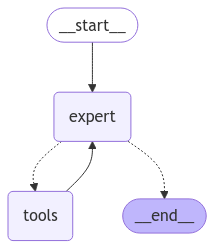

In [94]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [96]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="Is tanmay good for this job?")]
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Is tanmay good for this job?
================================== Ai Message ==================================
Tool Calls:
  get_job (call_2m7m)
 Call ID: call_2m7m
  Args:
    field: title
  get_job (call_gwt8)
 Call ID: call_gwt8
  Args:
    field: description
  get_resume (call_pf59)
 Call ID: call_pf59
  Args:
    field: name
================================= Tool Message =================================
Name: get_job

Machine Learning Engineer
================================= Tool Message =================================
Name: get_job

Learn more about applying for Machine Learning Engineer position at Accenture.
================================= Tool Message =================================
Name: get_resume

Tanmay Suhas Jagtap
================================== Ai Message ==================================
Tool Calls:
  get_resume (call_gx1q)
 Call ID: call_gx1q
  Args:
    field: work_experienc

In [97]:
messages = [HumanMessage(content="please elaborate")]
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Is tanmay good for this job?
================================== Ai Message ==================================
Tool Calls:
  get_job (call_2m7m)
 Call ID: call_2m7m
  Args:
    field: title
  get_job (call_gwt8)
 Call ID: call_gwt8
  Args:
    field: description
  get_resume (call_pf59)
 Call ID: call_pf59
  Args:
    field: name
================================= Tool Message =================================
Name: get_job

Machine Learning Engineer
================================= Tool Message =================================
Name: get_job

Learn more about applying for Machine Learning Engineer position at Accenture.
================================= Tool Message =================================
Name: get_resume

Tanmay Suhas Jagtap
================================== Ai Message ==================================
Tool Calls:
  get_resume (call_gx1q)
 Call ID: call_gx1q
  Args:
    field: work_experienc

In [98]:
messages = [HumanMessage(content="please write cover letter for tanmay so he can apply for this job")]
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Is tanmay good for this job?
================================== Ai Message ==================================
Tool Calls:
  get_job (call_2m7m)
 Call ID: call_2m7m
  Args:
    field: title
  get_job (call_gwt8)
 Call ID: call_gwt8
  Args:
    field: description
  get_resume (call_pf59)
 Call ID: call_pf59
  Args:
    field: name
================================= Tool Message =================================
Name: get_job

Machine Learning Engineer
================================= Tool Message =================================
Name: get_job

Learn more about applying for Machine Learning Engineer position at Accenture.
================================= Tool Message =================================
Name: get_resume

Tanmay Suhas Jagtap
================================== Ai Message ==================================
Tool Calls:
  get_resume (call_gx1q)
 Call ID: call_gx1q
  Args:
    field: work_experienc

In [99]:
messages = [HumanMessage(content="""based on the resume what changes will tanmay have to make in his resume so that he is in the top 1 percent of candidates for this role """)]
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Is tanmay good for this job?
================================== Ai Message ==================================
Tool Calls:
  get_job (call_2m7m)
 Call ID: call_2m7m
  Args:
    field: title
  get_job (call_gwt8)
 Call ID: call_gwt8
  Args:
    field: description
  get_resume (call_pf59)
 Call ID: call_pf59
  Args:
    field: name
================================= Tool Message =================================
Name: get_job

Machine Learning Engineer
================================= Tool Message =================================
Name: get_job

Learn more about applying for Machine Learning Engineer position at Accenture.
================================= Tool Message =================================
Name: get_resume

Tanmay Suhas Jagtap
================================== Ai Message ==================================
Tool Calls:
  get_resume (call_gx1q)
 Call ID: call_gx1q
  Args:
    field: work_experienc